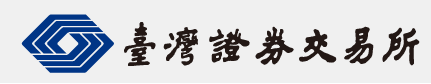

台灣證券交易所網站: https://www.twse.com.tw/zh/

程式參考網站: https://www.finlab.tw/Python-%E6%99%82%E9%96%93%E5%BA%8F%E5%88%97%E5%AF%A6%E4%BD%9C%EF%BC%81/

讀取 30天 資料

In [1]:
import requests
from io import StringIO
import pandas as pd
import numpy as np

def crawl_price(date):
    # 下載股價
    r = requests.post('http://www.twse.com.tw/exchangeReport/MI_INDEX?response=csv&date=' + str(date).split(' ')[0].replace('-','') + '&type=ALL')
    
    # 整理資料，變成表格
    ret = pd.read_csv(StringIO("\n".join([i.translate({ord(c): None for c in ' '}) 
                                        for i in r.text.split('\n') 
                                        if len(i.split('",')) == 17 and i[0] != '='])), header=0)
    ret = ret.set_index('證券代號')
    ret['成交金額'] = ret['成交金額'].str.replace(',','')
    ret['成交股數'] = ret['成交股數'].str.replace(',','')
    return ret

呼叫每日爬蟲，連續爬 n 天
接下來我們就來利用這個 function 幫我們爬最近30天的資料，並將數據存在 data 這個 variable 中：

一次爬 n_days 天的股價

大部分的天數都是 success 代表成功讀取資料，但是每間隔5天就會顯示兩次 fail，代表那可能是假日，然而不能保證就是了，也可能是你的網路斷掉XD，或是 code 有bug，就要單獨做測試，至少在我的電腦裡，它抓的滿好的。

In [2]:
import datetime
import time

data = {}
n_days = 30
date = datetime.datetime.now()
fail_count = 0
allow_continuous_fail_count = 5
while len(data) < n_days:

    print('parsing', date)
    # 使用 crawPrice 爬資料
    try:
        # 抓資料
        data[date.date()] = crawl_price(date)
        print('success!')
        fail_count = 0
    except:
        # 假日爬不到
        print('fail! check the date is holiday')
        fail_count += 1
        if fail_count == allow_continuous_fail_count:
            raise
            break
    
    # 減一天
    date -= datetime.timedelta(days=1)
    time.sleep(10)

parsing 2020-08-14 14:51:41.780966
success!
parsing 2020-08-13 14:51:41.780966
success!
parsing 2020-08-12 14:51:41.780966
success!
parsing 2020-08-11 14:51:41.780966
success!
parsing 2020-08-10 14:51:41.780966
success!
parsing 2020-08-09 14:51:41.780966
fail! check the date is holiday
parsing 2020-08-08 14:51:41.780966
fail! check the date is holiday
parsing 2020-08-07 14:51:41.780966
success!
parsing 2020-08-06 14:51:41.780966
success!
parsing 2020-08-05 14:51:41.780966
success!
parsing 2020-08-04 14:51:41.780966
success!
parsing 2020-08-03 14:51:41.780966
success!
parsing 2020-08-02 14:51:41.780966
fail! check the date is holiday
parsing 2020-08-01 14:51:41.780966
fail! check the date is holiday
parsing 2020-07-31 14:51:41.780966
success!
parsing 2020-07-30 14:51:41.780966
success!
parsing 2020-07-29 14:51:41.780966
success!
parsing 2020-07-28 14:51:41.780966
success!
parsing 2020-07-27 14:51:41.780966
success!
parsing 2020-07-26 14:51:41.780966
fail! check the date is holiday
parsi

In [14]:
data

{datetime.date(2020, 8, 14):        證券名稱      成交股數    成交筆數        成交金額     開盤價     最高價    最低價    收盤價  \
 證券代號                                                                      
 1101     台泥  36239984  14,561  1535910762   41.30   43.00  41.25  42.85   
 1101B  台泥乙特      4059       7      216137   53.10   53.30  53.10  53.30   
 1102     亞泥   6339031   2,759   262901331   40.80   41.75  40.80  41.50   
 1103     嘉泥    875525     303    14414158   16.30   16.60  16.30  16.55   
 1104     環泥    741559     421    13496736   18.15   18.30  18.10  18.25   
 ...     ...       ...     ...         ...     ...     ...    ...    ...   
 9944     新麗   2903525   1,293    64237220   21.55   22.95  21.35  22.35   
 9945    潤泰新   6312682   3,144   334379646   52.60   53.40  52.30  53.10   
 9946   三發地產    181682      86     3217753   17.70   17.80  17.60  17.75   
 9955     佳龍    399034     237     7571994   19.10   19.10  18.75  19.05   
 9958    世紀鋼   8058301   5,314   803494799  100.00  102.00  

整理 data 轉成 收盤價 time series
接下來我們來看一下得到了什麼：

In [11]:
data[datetime.date(2020,8,14)]

,證券名稱,成交股數,成交筆數,成交金額,開盤價,最高價,最低價,收盤價,漲跌(+/-),漲跌價差,最後揭示買價,最後揭示買量,最後揭示賣價,最後揭示賣量,本益比,Unnamed: 16
證券代號,,,,,,,,,,,,,,,,
1101,台泥,36239984,"14,561",1535910762,41.30,43.00,41.25,42.85,+,1.65,42.80,170,42.85,60,10.11,NaN
1101B,台泥乙特,4059,7,216137,53.10,53.30,53.10,53.30,NaN,0.00,53.10,1,53.30,19,0.00,NaN
1102,亞泥,6339031,"2,759",262901331,40.80,41.75,40.80,41.50,+,0.40,41.50,456,41.55,10,9.14,NaN
1103,嘉泥,875525,303,14414158,16.30,16.60,16.30,16.55,+,0.20,16.55,29,16.60,100,11.11,NaN
1104,環泥,741559,421,13496736,18.15,18.30,18.10,18.25,+,0.20,18.25,20,18.30,74,10.31,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,新麗,2903525,"1,293",64237220,21.55,22.95,21.35,22.35,+,1.10,22.35,42,22.45,23,0.00,NaN
9945,潤泰新,6312682,"3,144",334379646,52.60,53.40,52.30,53.10,-,0.30,53.10,70,53.20,136,7.10,NaN
9946,三發地產,181682,86,3217753,17.70,17.80,17.60,17.75,-,0.05,17.75,8,17.80,22,6.38,NaN


不同的日期，可以得到不同的表。但這並不是我們想要的，我們想要有 time series，也就是看到某個欄位隨時間變動的圖表，於是我們做以下的轉換：

# 挑選本益比小於20，大於 0 的股票

In [23]:
data[datetime.date(2020,8,14)]['收盤價']

,證券名稱,成交股數,成交筆數,成交金額,開盤價,最高價,最低價,收盤價,漲跌(+/-),漲跌價差,最後揭示買價,最後揭示買量,最後揭示賣價,最後揭示賣量,本益比,Unnamed: 16
證券代號,,,,,,,,,,,,,,,,
1101,台泥,36239984,"14,561",1535910762,41.30,43.00,41.25,42.85,+,1.65,42.80,170,42.85,60,10.11,NaN
1101B,台泥乙特,4059,7,216137,53.10,53.30,53.10,53.30,NaN,0.00,53.10,1,53.30,19,0.00,NaN
1102,亞泥,6339031,"2,759",262901331,40.80,41.75,40.80,41.50,+,0.40,41.50,456,41.55,10,9.14,NaN
1103,嘉泥,875525,303,14414158,16.30,16.60,16.30,16.55,+,0.20,16.55,29,16.60,100,11.11,NaN
1104,環泥,741559,421,13496736,18.15,18.30,18.10,18.25,+,0.20,18.25,20,18.30,74,10.31,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,新麗,2903525,"1,293",64237220,21.55,22.95,21.35,22.35,+,1.10,22.35,42,22.45,23,0.00,NaN
9945,潤泰新,6312682,"3,144",334379646,52.60,53.40,52.30,53.10,-,0.30,53.10,70,53.20,136,7.10,NaN
9946,三發地產,181682,86,3217753,17.70,17.80,17.60,17.75,-,0.05,17.75,8,17.80,22,6.38,NaN


In [28]:
data[datetime.date(2020,8,14)]['收盤價']

證券代號
1101     42.85
1101B    53.30
1102     41.50
1103     16.55
1104     18.25
         ...  
9944     22.35
9945     53.10
9946     17.75
9955     19.05
9958     98.50
Name: 收盤價, Length: 970, dtype: object

In [ ]:
for i int range(970)

In [25]:
if int(data[datetime.date(2020,8,14)]['收盤價']) < 10:
    print(data[datetime.date(2020,8,14)]['證券代號'])

TypeError: cannot convert the series to <class 'int'>

In [17]:
data[datetime.date(2020,8,14)]

,證券名稱,成交股數,成交筆數,成交金額,開盤價,最高價,最低價,收盤價,漲跌(+/-),漲跌價差,最後揭示買價,最後揭示買量,最後揭示賣價,最後揭示賣量,本益比,Unnamed: 16
證券代號,,,,,,,,,,,,,,,,
1101,台泥,36239984,"14,561",1535910762,41.30,43.00,41.25,42.85,+,1.65,42.80,170,42.85,60,10.11,NaN
1101B,台泥乙特,4059,7,216137,53.10,53.30,53.10,53.30,NaN,0.00,53.10,1,53.30,19,0.00,NaN
1102,亞泥,6339031,"2,759",262901331,40.80,41.75,40.80,41.50,+,0.40,41.50,456,41.55,10,9.14,NaN
1103,嘉泥,875525,303,14414158,16.30,16.60,16.30,16.55,+,0.20,16.55,29,16.60,100,11.11,NaN
1104,環泥,741559,421,13496736,18.15,18.30,18.10,18.25,+,0.20,18.25,20,18.30,74,10.31,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,新麗,2903525,"1,293",64237220,21.55,22.95,21.35,22.35,+,1.10,22.35,42,22.45,23,0.00,NaN
9945,潤泰新,6312682,"3,144",334379646,52.60,53.40,52.30,53.10,-,0.30,53.10,70,53.20,136,7.10,NaN
9946,三發地產,181682,86,3217753,17.70,17.80,17.60,17.75,-,0.05,17.75,8,17.80,22,6.38,NaN


In [15]:
data[(pd.to_numeric(data['本益比'], errors='coerce') < 20) & (pd.to_numeric(data['本益比'], errors='coerce') > 0)]

KeyError: '本益比'

在下面的程式中，現在我們只拿所有股票的 收盤價，並建構 close 這個 dataframe

In [5]:
close = pd.DataFrame({k:d['收盤價'] for k,d in data.items()}).transpose()
close.index = pd.to_datetime(close.index)
close

,1101,1101B,1102,1103,1104,1108,1109,1110,1201,1203,...,9940,9941,9941A,9942,9943,9944,9945,9946,9955,9958
2020-08-14,42.85,53.30,41.50,16.55,18.25,10.25,18.00,16.20,20.60,30.10,...,29.75,114.50,54.00,63.90,64.90,22.35,53.10,17.75,19.05,98.50
2020-08-13,41.20,53.30,41.10,16.35,18.05,9.97,17.25,16.10,20.60,30.15,...,30.10,113.00,54.00,63.80,64.50,21.25,53.40,17.80,18.75,99.40
2020-08-12,41.00,53.20,40.75,16.40,17.70,9.96,17.20,16.10,20.05,30.25,...,30.10,110.00,53.80,63.80,64.90,21.90,53.00,17.95,19.35,98.20
2020-08-11,46.50,54.90,40.95,16.45,17.20,9.97,17.15,16.05,19.90,30.20,...,30.10,109.00,53.90,63.90,65.00,22.15,52.70,18.00,19.65,99.10
2020-08-10,46.60,55.00,41.20,16.50,17.15,9.93,17.15,16.40,20.10,30.35,...,30.05,107.00,53.90,63.70,65.00,22.45,53.30,18.40,20.55,98.40
2020-08-07,47.10,54.70,41.05,16.45,17.05,9.71,17.20,16.10,20.00,30.40,...,29.60,106.00,53.80,63.60,65.10,22.80,53.00,18.35,21.75,100.00
2020-08-06,47.15,55.00,41.05,16.65,17.25,9.76,17.15,16.05,20.05,30.40,...,29.65,106.00,53.80,63.70,65.50,23.85,53.40,18.35,20.90,93.70
2020-08-05,46.45,55.10,40.85,16.60,17.20,9.79,17.15,16.30,20.10,29.95,...,29.95,105.50,53.80,63.80,65.40,21.95,53.00,18.10,21.15,93.60
2020-08-04,45.40,55.00,40.45,16.35,17.00,9.55,17.10,16.30,20.15,29.95,...,29.95,104.50,53.90,63.60,65.40,21.55,52.20,18.00,20.70,94.00
2020-08-03,44.95,55.00,40.00,16.35,16.95,9.47,17.05,16.20,19.90,29.95,...,28.50,104.00,53.90,63.60,64.80,21.70,52.20,17.90,19.95,93.00


In [6]:
openPrice = pd.DataFrame({k:d['開盤價'] for k,d in data.items()}).transpose()
openPrice.index = pd.to_datetime(openPrice.index)
openPrice

,1101,1101B,1102,1103,1104,1108,1109,1110,1201,1203,...,9940,9941,9941A,9942,9943,9944,9945,9946,9955,9958
2020-08-14,41.30,53.10,40.80,16.30,18.15,9.98,17.30,16.10,20.60,30.10,...,30.10,113.00,53.90,63.80,64.30,21.55,52.60,17.70,19.10,100.00
2020-08-13,41.30,53.60,41.00,16.55,17.75,10.00,17.25,16.15,20.10,30.25,...,30.15,110.50,53.90,64.00,64.90,22.00,53.20,17.90,19.70,99.40
2020-08-12,41.40,53.60,41.00,16.45,17.60,9.98,17.15,16.05,19.90,30.10,...,30.05,109.00,53.80,63.90,65.10,22.40,52.70,17.80,19.55,101.00
2020-08-11,46.55,54.70,41.20,16.50,17.20,10.00,17.30,16.40,20.10,30.40,...,30.30,108.00,53.70,63.90,65.10,22.50,53.50,18.35,20.05,99.90
2020-08-10,46.90,54.70,41.20,16.50,17.10,9.71,17.10,16.10,20.05,30.25,...,29.70,105.50,53.60,63.80,64.90,22.80,53.10,18.45,22.20,99.90
2020-08-07,47.50,54.60,41.05,16.65,17.30,9.71,17.20,16.10,20.10,30.40,...,29.65,106.00,53.80,63.80,65.50,23.95,53.40,18.25,21.40,95.90
2020-08-06,46.95,55.00,41.40,16.90,17.30,9.80,17.25,16.30,20.25,30.10,...,30.00,106.00,53.90,64.00,65.40,22.50,53.50,18.30,21.40,94.50
2020-08-05,45.60,55.00,40.60,16.40,17.00,9.56,17.10,16.20,20.15,29.85,...,29.95,104.50,53.80,63.60,65.50,21.60,51.90,17.90,21.45,94.40
2020-08-04,44.95,55.00,40.05,16.45,17.00,9.47,17.00,16.15,20.00,29.95,...,28.60,105.00,53.70,63.60,64.80,22.00,52.50,17.90,20.50,94.10
2020-08-03,45.00,54.60,40.00,16.50,17.10,9.53,16.85,16.20,20.20,30.10,...,28.75,106.00,53.80,64.00,65.80,21.90,51.30,18.20,20.60,93.40


In [7]:
highPrice = pd.DataFrame({k:d['最高價'] for k,d in data.items()}).transpose()
highPrice.index = pd.to_datetime(highPrice.index)
highPrice

,1101,1101B,1102,1103,1104,1108,1109,1110,1201,1203,...,9940,9941,9941A,9942,9943,9944,9945,9946,9955,9958
2020-08-14,43.00,53.30,41.75,16.60,18.30,10.50,18.00,16.40,20.75,30.20,...,30.10,114.50,54.00,63.90,65.50,22.95,53.40,17.80,19.10,102.00
2020-08-13,41.60,53.60,41.50,16.55,18.10,10.05,17.30,16.40,20.60,30.35,...,30.25,113.00,54.10,64.10,64.90,22.10,53.50,17.90,19.70,101.00
2020-08-12,41.45,53.60,41.00,16.55,18.00,9.99,17.20,16.10,20.10,30.25,...,30.15,110.50,53.80,63.90,65.10,22.40,53.10,18.20,19.55,101.00
2020-08-11,46.75,54.90,41.25,16.55,17.30,10.00,17.30,16.40,20.10,30.45,...,30.30,111.50,53.90,63.90,65.20,22.50,53.60,18.35,20.55,102.00
2020-08-10,47.00,55.00,41.35,16.60,17.25,10.10,17.15,16.40,20.10,30.45,...,30.25,107.50,53.90,63.80,65.20,23.35,53.80,18.70,22.45,104.00
2020-08-07,47.55,55.00,41.40,16.75,17.35,9.73,17.25,16.45,20.20,30.70,...,29.75,106.50,53.80,63.80,65.50,24.80,53.40,18.55,21.90,100.00
2020-08-06,47.15,55.00,41.45,16.90,17.40,9.88,17.30,16.30,20.25,30.55,...,30.00,106.00,53.90,64.10,65.70,24.10,53.90,18.40,21.85,95.90
2020-08-05,46.65,55.10,41.10,17.10,17.20,9.81,17.15,16.35,20.20,30.00,...,30.00,105.50,53.80,64.50,65.80,22.15,53.00,18.10,22.10,94.60
2020-08-04,45.65,55.00,40.75,16.45,17.05,9.57,17.10,16.30,20.15,30.00,...,29.95,105.50,53.90,63.70,65.40,22.10,52.80,18.10,21.00,96.90
2020-08-03,45.00,55.00,40.10,16.55,17.10,9.53,17.05,16.20,20.20,30.15,...,28.80,106.00,53.90,64.10,65.80,22.50,52.50,18.25,20.75,93.60


In [8]:
lowPrice = pd.DataFrame({k:d['最低價'] for k,d in data.items()}).transpose()
lowPrice.index = pd.to_datetime(lowPrice.index)
lowPrice

,1101,1101B,1102,1103,1104,1108,1109,1110,1201,1203,...,9940,9941,9941A,9942,9943,9944,9945,9946,9955,9958
2020-08-14,41.25,53.10,40.80,16.30,18.10,9.96,17.30,16.00,20.50,30.00,...,29.75,112.50,53.80,63.60,64.30,21.35,52.30,17.60,18.75,98.50
2020-08-13,41.00,53.30,40.90,16.30,17.75,9.97,17.20,16.10,20.05,30.15,...,30.00,110.50,53.90,63.60,64.40,20.95,52.80,17.20,18.70,95.30
2020-08-12,40.85,53.00,40.70,16.35,17.55,9.89,17.05,16.05,19.85,30.10,...,29.80,109.00,53.80,63.60,64.70,21.55,52.10,17.80,18.65,98.10
2020-08-11,46.50,54.70,40.90,16.30,17.20,9.84,17.15,16.05,19.65,30.20,...,29.95,108.00,53.70,63.70,64.90,21.80,52.50,17.65,19.55,98.00
2020-08-10,46.50,54.70,41.00,16.40,17.10,9.69,17.05,16.10,19.90,30.25,...,29.60,105.50,53.60,63.60,64.80,22.20,53.00,18.35,20.55,98.00
2020-08-07,46.95,54.60,41.00,16.40,17.05,9.67,17.05,15.95,19.95,30.40,...,29.55,105.50,53.70,63.50,64.90,22.80,52.60,18.25,21.10,95.10
2020-08-06,46.50,55.00,40.90,16.55,17.20,9.70,17.15,16.00,20.05,30.00,...,28.80,105.00,53.80,63.60,65.40,22.15,53.10,18.05,20.60,93.50
2020-08-05,45.60,55.00,40.55,16.40,17.00,9.56,17.10,16.20,20.05,29.85,...,29.65,104.00,53.50,63.60,65.00,21.55,51.90,17.75,21.15,93.10
2020-08-04,44.95,55.00,40.00,16.30,16.95,9.47,17.00,16.10,19.95,29.95,...,28.60,104.50,53.70,63.50,64.80,21.40,51.70,17.80,20.10,93.20
2020-08-03,44.70,54.60,39.95,16.25,16.90,9.42,16.85,15.85,19.85,29.95,...,28.45,103.50,53.80,63.50,64.00,21.15,51.30,17.75,19.85,92.20


In [10]:
Volume = pd.DataFrame({k:d['成交股數'] for k,d in data.items()}).transpose()
Volume.index = pd.to_datetime(Volume.index)
Volume

,1101,1101B,1102,1103,1104,1108,1109,1110,1201,1203,...,9940,9941,9941A,9942,9943,9944,9945,9946,9955,9958
2020-08-14,36239984,4059,6339031,875525,741559,1620625,399997,73000,1373038,100222,...,331874,845561,10200,57413,144352,2903525,6312682,181682,399034,8058301
2020-08-13,31054952,6000,5615167,663139,1167917,520145,187499,116000,1684544,32260,...,297404,828300,18873,67000,190762,1052080,5314569,419492,703940,10482135
2020-08-12,88740748,9609,7912994,581799,997046,240000,182499,25000,791777,39711,...,309064,403008,2580,49100,62029,626665,4370246,201027,1174250,6765464
2020-08-11,32519966,46068,4345532,888202,205322,360100,116300,145000,825260,119423,...,594819,960485,14279,76214,70414,1996001,3759473,656399,1396131,13484552
2020-08-10,27092060,4718,5734649,459470,140030,539115,65150,47002,830473,26261,...,671425,388361,15968,118000,91353,1923010,2573812,392633,2162556,26239349
2020-08-07,30533956,5058,7757757,1308346,167225,214294,143050,71000,1067102,36357,...,240846,219782,5582,114300,110865,9606071,3808264,431575,2523242,26551813
2020-08-06,34077859,3321,6754839,639215,312351,240200,225121,28000,914604,198945,...,453883,279309,2150,80600,76457,8128341,5168839,386831,1285898,5345880
2020-08-05,41542772,7332,10604969,1983414,232229,236300,175933,23181,487438,25283,...,483973,466719,5582,40560,96125,939099,3840348,495011,2713333,3832820
2020-08-04,22411736,3041,7323732,379590,162341,251000,92409,27000,438553,21303,...,1111624,169222,4455,73200,105130,1328305,3794994,421013,1143707,12233819
2020-08-03,13546103,2683,7795217,518214,224174,208063,148898,71000,1035060,54743,...,345564,370999,5000,71115,298485,2660100,6578313,713561,792672,4677762
